In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_unweighted, venn3_unweighted

## Configuration for datasets

- Spark executed on CloudSpeller groupOrtho1.txt file, with different tree syntax.
- settings

```
-p 1
--alphabet 2
--degen 2
--min_len 8
--max_len 9
```

- CloudSpeller executed on groupOrtho1.txt using settings:

```
sMotifAlgorithm_Type=EXACT
sIndex_Structure=GST
sNode_Decoration_Type=BITS
sConservationScore=BLS
sBLS_Thresholds=15,50,60,70,90,95
iKmin=8
iKmax=8
iMax_Degenerate_Positions=2
sMotif_Alphabet=TWOFOLDSANDN
sFilter_Type=SIMULTANEOUS
iFamily_Cutoff=1
iConfidence_Cutoff=50
iBackground_Group_Size=1000
```

## Import and compare datasets

In [2]:
n_thresholds = 6

In [3]:
df_cloud = pd.read_csv("cloud.tsv", delim_whitespace=True, header=None,
                      names=[
                          "group",
                          "motif",
                          *[f"fc {x}" for x in range(6)],
                          *[f"conf {x}" for x in range(6)],
                      ])

In [4]:
df_cloud.iloc[:, 8:] /= 100
df_cloud

,group,motif,fc 0,fc 1,fc 2,fc 3,fc 4,fc 5,conf 0,conf 1,conf 2,conf 3,conf 4,conf 5
0,AAAAAAAC,AAAAAAAC,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.25,1.0
1,AAAAAAAC,CAAAAAAA,7,5,5,3,2,1,0.142857,0.000000,0.000000,0.333333,0.25,1.0
2,AAAAAAAG,AAAAAAGA,2,2,2,1,1,1,0.000000,0.000000,0.000000,0.000000,0.50,1.0
3,AAAAAAAG,AAAAAAAG,9,9,9,2,1,0,0.444444,0.555556,0.611111,0.500000,0.50,0.0
4,AAAAAAAG,AAAAAGAA,3,3,3,2,1,0,0.000000,0.000000,0.000000,0.500000,0.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526898,CCCGGGKK,GKKGCGCC,4,4,3,1,1,0,0.750000,0.750000,0.666667,1.000000,1.00,0.0
1526899,CCCGGGKK,KCKCCGGG,1,1,1,1,1,0,0.000000,0.000000,0.000000,1.000000,1.00,0.0
1526900,CCCGGGKK,GGKKGCCC,2,1,1,0,0,0,0.500000,0.000000,0.000000,0.000000,0.00,0.0
1526901,CCCGGGKK,GKCKCGGC,2,0,0,0,0,0,0.500000,0.000000,0.000000,0.000000,0.00,0.0


In [5]:
df_spark = pd.read_csv("spark.tsv", delim_whitespace=True, header=None,
                      names=[
                          "motif",
                          *[f"fc {x}" for x in range(6)],
                          *[f"conf {x}" for x in range(6)],
                      ])
df_spark

,motif,fc 0,fc 1,fc 2,fc 3,fc 4,fc 5,conf 0,conf 1,conf 2,conf 3,conf 4,conf 5
0,AAATAATA,5,4,4,3,1,1,0.200000,0.25,0.500000,0.666667,0.0,1.0
1,AAATAAAT,5,3,3,2,1,1,0.200000,0.00,0.333333,0.500000,0.0,1.0
2,AATAATAA,4,3,2,2,1,0,0.000000,0.00,0.000000,0.500000,0.0,0.0
3,AATAAAAT,5,5,4,1,0,0,0.200000,0.40,0.500000,0.000000,0.0,0.0
4,TAATAAAA,3,3,3,3,1,0,0.000000,0.00,0.333333,0.666667,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399998,GGSGSGGG,1,1,1,1,0,0,0.000000,0.00,0.000000,1.000000,0.0,0.0
2399999,SGGGGSGG,2,2,1,0,0,0,0.500000,0.50,0.000000,0.000000,0.0,0.0
2400000,GSGGSGGG,3,1,1,1,0,0,0.666667,0.00,0.000000,1.000000,0.0,0.0
2400001,GGSGGGSG,2,2,1,0,0,0,0.500000,0.50,0.000000,0.000000,0.0,0.0


## Compare common spark and cloud motifs

In [6]:
def compare_fc(left, right):
    left = left.copy()
    right = right.copy()
    left.columns = right.columns
    comp = left.compare(right)
    return comp

def count_difference(comp):
    return comp.diff(axis=1).iloc[:,list(range(1,comp.shape[1],2))]

def get_differences_mask(left, right):
    left = left.copy()
    right = right.copy()
    left.columns = right.columns
    return ~np.isclose(left, right).all(axis=1)

In [7]:
pd.set_option('display.max_columns', None)

def compare_common_motifs(df_l, df_r, suffix_l, suffix_r):
    common = set(df_l.motif) & set(df_r.motif)
    df = pd.merge(df_l,
        df_r,
        on="motif", suffixes=(suffix_l, suffix_r))
    return df[df.motif.isin(common)]

common_s_c = compare_common_motifs(df_spark, df_cloud, "_s", "_c")
common_s_c

,motif,fc 0_s,fc 1_s,fc 2_s,fc 3_s,fc 4_s,fc 5_s,conf 0_s,conf 1_s,conf 2_s,conf 3_s,conf 4_s,conf 5_s,group,fc 0_c,fc 1_c,fc 2_c,fc 3_c,fc 4_c,fc 5_c,conf 0_c,conf 1_c,conf 2_c,conf 3_c,conf 4_c,conf 5_c
0,AAATAATA,5,4,4,3,1,1,0.200000,0.25,0.500000,0.666667,0.0,1.0,AAAAAATT,5,4,4,3,1,1,0.200000,0.25,0.25,0.666667,0.0,1.0
1,AAATAAAT,5,3,3,2,1,1,0.200000,0.00,0.333333,0.500000,0.0,1.0,AAAAAATT,5,3,3,2,1,1,0.200000,0.00,0.00,0.500000,0.0,1.0
2,AATAATAA,4,3,2,2,1,0,0.000000,0.00,0.000000,0.500000,0.0,0.0,AAAAAATT,4,3,3,2,1,0,0.000000,0.00,0.00,0.500000,0.0,0.0
3,TAATAAAA,3,3,3,3,1,0,0.000000,0.00,0.333333,0.666667,0.0,0.0,AAAAAATT,3,3,3,3,1,0,0.000000,0.00,0.00,0.666667,0.0,0.0
4,ATAATAAA,4,4,3,2,0,0,0.000000,0.25,0.333333,0.500000,0.0,0.0,AAAAAATT,4,4,3,2,1,0,0.000000,0.25,0.00,0.500000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497216,GSCGGSCC,2,1,1,1,0,0,0.000000,0.00,0.000000,1.000000,0.0,0.0,CCCGGGSS,2,1,1,1,0,0,0.000000,0.00,0.00,1.000000,0.0,0.0
1497217,GGCSCCSG,3,2,1,0,0,0,0.333333,0.50,0.000000,0.000000,0.0,0.0,CCCGGGSS,3,2,1,0,0,0,0.333333,0.50,0.00,0.000000,0.0,0.0
1497218,GCSGGSCC,2,1,1,1,0,0,0.000000,0.00,0.000000,1.000000,0.0,0.0,CCCGGGSS,2,1,1,1,0,0,0.000000,0.00,0.00,1.000000,0.0,0.0
1497219,CSGGCCSG,3,2,2,2,0,0,0.333333,0.50,0.500000,1.000000,0.0,0.0,CCCGGGSS,3,2,2,2,0,0,0.333333,0.50,0.50,1.000000,0.0,0.0


In [9]:
df_iterator = pd.read_csv("serialized_counted_group1_iterator_output.gz", delim_whitespace=True, header=None,
                      names=[
                          "group",
                          "motif",
                          *[f"fc {x}" for x in range(6)],
                      ]) 
df_iterator

,group,motif,fc 0,fc 1,fc 2,fc 3,fc 4,fc 5
0,AAAAAAAA,AAAAAAAA,9,8,5,3,3,3
1,AAAAAAAC,AAAAAAAC,4,3,2,2,2,1
2,AAAAAAAM,AAAAAAAM,9,8,5,3,3,3
3,AAAAAAAG,AAAAAAAG,9,9,9,2,1,0
4,AAAAAAAR,AAAAAAAR,10,10,9,8,7,3
...,...,...,...,...,...,...,...,...
3871908,AACGNNTT,NNTTGACA,9,8,7,5,5,2
3871909,AAGGNNTT,NNTTGAGA,9,8,6,6,3,1
3871910,AACGNNTT,NNTTGCAA,6,5,3,1,1,1
3871911,AAGGNNTT,NNTTGGAA,5,5,5,3,1,0


## Check algo of Spark implementation

In [10]:
## mapsideCombine of motifIterator 
df_iterator.motif.unique().size

3871913

In [11]:
df_small = df_iterator[:12].copy()
df_small

,group,motif,fc 0,fc 1,fc 2,fc 3,fc 4,fc 5
0,AAAAAAAA,AAAAAAAA,9,8,5,3,3,3
1,AAAAAAAC,AAAAAAAC,4,3,2,2,2,1
2,AAAAAAAM,AAAAAAAM,9,8,5,3,3,3
3,AAAAAAAG,AAAAAAAG,9,9,9,2,1,0
4,AAAAAAAR,AAAAAAAR,10,10,9,8,7,3
5,AAAAAAAS,AAAAAAAS,9,9,9,5,4,1
6,AAAAAAAT,AAAAAAAT,8,6,6,5,4,2
7,AAAAAAAW,AAAAAAAW,10,9,7,6,6,5
8,AAAAAAAY,AAAAAAAY,10,9,7,6,6,5
9,AAAAAAAK,AAAAAAAK,10,10,10,9,7,3


In [27]:
from itertools import permutations
from math import factorial
from functools import partial

def get_number_of_permutations(s, method="fac"):
    if method == "fac":
        output = 1
        for c in set(s):
            output *= factorial(s.count(c))
        return int(factorial(len(s)) / output)
    else:
        return len(set(permutations(s)))

def find_k_median(arr, k):
    print(f"k {k}")
    pivot = len(arr) // 2
    print(f"Pivot {pivot}")
    left, right = np.array_split(np.partition(arr, pivot), [pivot])
    print(f"Left {pivot}")
    print(f"Right {pivot}")
    if len(left) == k:
        return arr[pivot]
    elif len(left) == 0:
        left, right = np.array_split(np.partition(arr, pivot), [pivot])
        find_k_median(right, k - len(left))
    elif len(right) < k:
        find_k_median(right, k - len(left))
    else:
        find_k_median(left, k)

def find_median(arr):
    return find_k_median(arr, (len(arr) - 1) / 2)

def find_median_sort(arr, prefer="left"):
    arr = np.sort(arr)
    if len(arr) % 2 == 0:
        if prefer == "left":
            index = len(arr) // 2 - 1
        else:
            index = len(arr) // 2
    else:
        index = len(arr) // 2
    return arr[index]
    
def get_median_per_threshold(df, n_thresholds=6, method="median") -> np.ndarray:
    if method == "perm":
        # find the maximum number of permutations the key can represent
        perms = get_number_of_permutations(df.iloc[0, 0])
        if perms == 1:
            # return first value if this is only one
            return df.iloc[0, 2:].values
        else:
            # else brute force calculate the remaining mean
            nr = (perms + 1) / 2
            arr = np.zeros(n_thresholds)
            # return zero if amount of rows is more than double the permutations
            if df.shape[0] > nr:
                k = df.shape[0] - nr - 1
                for i in range(n_thresholds):
                    # find the mean for each threshold using divide-and-conquer
                    arr[i] = find_k_median(df[2+i], k)
            return arr
    elif method == "sort_left":
        return df.iloc[:,2:].apply(partial(find_median_sort, prefer="left"))
    elif method == "sort_right":
        return df.iloc[:,2:].apply(partial(find_median_sort, prefer="right"))
    else:
        return df.iloc[:,2:].median()

In [24]:
find_median_sort(np.array([1,1,3]), prefer="right")

1

In [21]:
find_median_sort(np.array([1,1,2,3]), prefer="right")

2

In [20]:
find_median_sort(np.array([1,1,2,3]))

1

In [12]:
arr = np.array([1, 2, 2, 3])

print(arr.mean())
print(find_median(arr))

2.0
k 1.5
Pivot 2
Left 2
Right 2
k 1.5
Pivot 1
Left 1
Right 1
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivot 0
Left 0
Right 0
k 0.5
Pivo

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/miniconda3/envs/motif_comparison/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-e6b68960b062>", line 4, in <module>
    print(find_median(arr))
  File "<ipython-input-12-74d3e04550d8>", line 31, in find_median
    return find_k_median(arr, (len(arr) - 1) / 2)
  File "<ipython-input-12-74d3e04550d8>", line 28, in find_k_median
    find_k_median(left, k)
  File "<ipython-input-12-74d3e04550d8>", line 26, in find_k_median
    find_k_median(right, k - len(left))
  File "<ipython-input-12-74d3e04550d8>", line 24, in find_k_median
    find_k_median(right, k - len(left))
  File "<ipython-input-12-74d3e04550d8>", line 24, in find_k_median
    find_k_median(right, k - len(left))
  File "<ipython-input-12-74d3e04550d8>", line 24, in find_k_median
    find_k_median(right, k - len(left))
  [Previous line repeated 2939 more times]
  F

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/miniconda3/envs/motif_comparison/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-e6b68960b062>", line 4, in <module>
    print(find_median(arr))
  File "<ipython-input-12-74d3e04550d8>", line 31, in find_median
    return find_k_median(arr, (len(arr) - 1) / 2)
  File "<ipython-input-12-74d3e04550d8>", line 28, in find_k_median
    find_k_median(left, k)
  File "<ipython-input-12-74d3e04550d8>", line 26, in find_k_median
    find_k_median(right, k - len(left))
  File "<ipython-input-12-74d3e04550d8>", line 24, in find_k_median
    find_k_median(right, k - len(left))
  File "<ipython-input-12-74d3e04550d8>", line 24, in find_k_median
    find_k_median(right, k - len(left))
  File "<ipython-input-12-74d3e04550d8>", line 24, in find_k_median
    find_k_median(right, k - len(left))
  [Previous line repeated 2939 more times]
  F

TypeError: object of type 'NoneType' has no len()

In [ ]:
np.split(np.array([1, 2, 2, 3]), [0])


In [ ]:
len([])

In [ ]:
# calculating number of partition methods are equivalent
import random

for s in ["".join([random.choice("ACTGN") for _ in range(8)]) for _ in range(100)]:
    fac = get_number_of_permutations(s)
    perm = get_number_of_permutations(s, method=None)
    if fac != perm:
        print(fac)
        print(perm)
        print()

In [ ]:
df_small.groupby("group").apply(get_median_per_threshold)

In [ ]:
# add medians for each group to motifs
df_medians = df_small.join(df_small.groupby("group").apply(get_median_per_threshold), on="group", rsuffix="_median")
df_medians

In [32]:
# F family_count
# f_bg = median
# conf = 
# filter, pass if family_count >= family_count_cutoff and conf >= confidence_score_cutoff


def process(df, method="median", family_count_cutoff=1, confidence_score_cutoff=.5):
    df_m = df.groupby("group").apply(partial(get_median_per_threshold, method=method))
    df_medians = df.join(df_m, on="group", rsuffix="_median")
    f = df_medians.iloc[:,2:8]
    f_bg = df_medians.iloc[:,8:]
    f_bg.columns = f.columns
    mask = f <= f_bg
    conf = (f - f_bg) / f
    conf[mask] = .0
    filter_mask = (f >= family_count_cutoff) & (conf >= confidence_score_cutoff)
    conf.columns = [f"conf {x.split()[1]}" for x in conf.columns]
    output = pd.concat([df, conf], axis=1)
    output = output[filter_mask.any(axis=1)]
    return output

In [35]:
process(df_small, method="sort_left")

,group,motif,fc 0,fc 1,fc 2,fc 3,fc 4,fc 5,conf 0,conf 1,conf 2,conf 3,conf 4,conf 5
1,AAAAAAAC,AAAAAAAC,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.0,1.0
11,AAAAAAAC,AAAAAACA,7,7,6,3,2,0,0.428571,0.571429,0.666667,0.333333,0.0,0.0


In [36]:
process(df_small, method="sort_right")

,group,motif,fc 0,fc 1,fc 2,fc 3,fc 4,fc 5,conf 0,conf 1,conf 2,conf 3,conf 4,conf 5


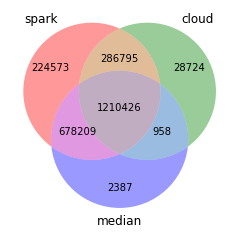

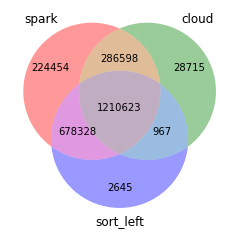

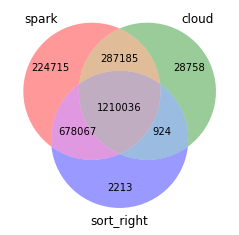

In [43]:
methods = ["median","sort_left", "sort_right"]
for m in methods:
    df = process(df_iterator, method=m)
    venn3_unweighted([
        set(x) for x in [
            df_spark.motif,
            df_cloud.motif,
            df.motif,
        ]
    ], set_labels=["spark", "cloud", m])
    plt.show()

In [47]:
df_new_m = process(df_iterator, method="median")
df_new_sl = process(df_iterator, method="sort_left")
df_new_sr = process(df_iterator, method="sort_right")

In [48]:
df_new_m_v_s = compare_common_motifs(df_new_m, df_spark, "_new_m", "_s")
df_new_sl_v_s = compare_common_motifs(df_new_sl, df_spark, "_new_sl", "_s")
df_new_sr_v_s = compare_common_motifs(df_new_sr, df_spark, "_new_sr", "_s")

In [49]:
df_new_m_v_s

,group,motif,fc 0_new_m,fc 1_new_m,fc 2_new_m,fc 3_new_m,fc 4_new_m,fc 5_new_m,conf 0_new_m,conf 1_new_m,conf 2_new_m,conf 3_new_m,conf 4_new_m,conf 5_new_m,fc 0_s,fc 1_s,fc 2_s,fc 3_s,fc 4_s,fc 5_s,conf 0_s,conf 1_s,conf 2_s,conf 3_s,conf 4_s,conf 5_s
0,AAAAAAAC,AAAAAAAC,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000
1,AAAAAAAG,AAAAAAAG,9,9,9,2,1,0,0.444444,0.555556,0.611111,0.500000,0.500000,0.000000,9,9,9,2,1,0,0.333333,0.444444,0.555556,0.500000,0.000000,0.000000
2,AAAAAAAT,AAAAAAAT,8,6,6,5,4,2,0.062500,0.000000,0.083333,0.400000,0.500000,0.500000,8,6,6,5,4,2,0.000000,0.000000,0.000000,0.400000,0.500000,0.500000
3,AAAAAAAC,AAAAAACA,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000
4,AAAAAACC,AAAAAACC,2,2,2,0,0,0,0.000000,0.250000,0.500000,0.000000,0.000000,0.000000,2,2,2,0,0,0,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888630,AAAGNNTT,NNTTGAAA,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667
1888631,AAGGNNTT,NNTTGAAG,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667
1888632,AACGNNTT,NNTTGACA,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000
1888633,AAGGNNTT,NNTTGAGA,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000


In [53]:
df_new_sl_v_s

,group,motif,fc 0_new_sl,fc 1_new_sl,fc 2_new_sl,fc 3_new_sl,fc 4_new_sl,fc 5_new_sl,conf 0_new_sl,conf 1_new_sl,conf 2_new_sl,conf 3_new_sl,conf 4_new_sl,conf 5_new_sl,fc 0_s,fc 1_s,fc 2_s,fc 3_s,fc 4_s,fc 5_s,conf 0_s,conf 1_s,conf 2_s,conf 3_s,conf 4_s,conf 5_s
0,AAAAAAAC,AAAAAAAC,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000
1,AAAAAAAG,AAAAAAAG,9,9,9,2,1,0,0.555556,0.666667,0.666667,0.500000,1.000000,0.000000,9,9,9,2,1,0,0.333333,0.444444,0.555556,0.500000,0.000000,0.000000
2,AAAAAAAT,AAAAAAAT,8,6,6,5,4,2,0.125000,0.000000,0.166667,0.400000,0.500000,0.500000,8,6,6,5,4,2,0.000000,0.000000,0.000000,0.400000,0.500000,0.500000
3,AAAAAAAC,AAAAAACA,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000
4,AAAAAACC,AAAAAACC,2,2,2,0,0,0,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,2,2,2,0,0,0,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888946,AAAGNNTT,NNTTGAAA,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667
1888947,AAGGNNTT,NNTTGAAG,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667
1888948,AACGNNTT,NNTTGACA,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000
1888949,AAGGNNTT,NNTTGAGA,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000


In [54]:
df_new_sr_v_s

,group,motif,fc 0_new_sr,fc 1_new_sr,fc 2_new_sr,fc 3_new_sr,fc 4_new_sr,fc 5_new_sr,conf 0_new_sr,conf 1_new_sr,conf 2_new_sr,conf 3_new_sr,conf 4_new_sr,conf 5_new_sr,fc 0_s,fc 1_s,fc 2_s,fc 3_s,fc 4_s,fc 5_s,conf 0_s,conf 1_s,conf 2_s,conf 3_s,conf 4_s,conf 5_s
0,AAAAAAAC,AAAAAAAC,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000
1,AAAAAAAG,AAAAAAAG,9,9,9,2,1,0,0.333333,0.444444,0.555556,0.500000,0.000000,0.000000,9,9,9,2,1,0,0.333333,0.444444,0.555556,0.500000,0.000000,0.000000
2,AAAAAAAT,AAAAAAAT,8,6,6,5,4,2,0.000000,0.000000,0.000000,0.400000,0.500000,0.500000,8,6,6,5,4,2,0.000000,0.000000,0.000000,0.400000,0.500000,0.500000
3,AAAAAAAC,AAAAAACA,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000
4,AAAAAACC,AAAAAACC,2,2,2,0,0,0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2,2,2,0,0,0,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888098,AAAGNNTT,NNTTGAAA,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667
1888099,AAGGNNTT,NNTTGAAG,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667
1888100,AACGNNTT,NNTTGACA,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000
1888101,AAGGNNTT,NNTTGAGA,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000


In [50]:
comp_new_m_v_s = compare_fc(df_new_m_v_s.iloc[:, 8:14], df_new_m_v_s.iloc[:, 20:])
comp_new_m_v_s

conf 0_s            conf 1_s            conf 2_s            conf 3_s  \
             self     other      self     other      self     other      self   
1        0.444444  0.333333  0.555556  0.444444  0.611111  0.555556       NaN   
2        0.062500  0.000000       NaN       NaN  0.083333  0.000000       NaN   
3        0.142857  0.142857  0.285714  0.285714  0.166667  0.166667  0.333333   
4        0.000000  0.500000  0.250000  0.500000       NaN       NaN       NaN   
5        0.222222  0.222222  0.222222  0.222222       NaN       NaN       NaN   
...           ...       ...       ...       ...       ...       ...       ...   
1888629       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1888630       NaN       NaN       NaN       NaN  0.222222  0.222222  0.444444   
1888631       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1888632  0.222222  0.222222       NaN       NaN  0.285714  0.285714       NaN   
1888633  0.222222  0.222222       NaN       NaN       NaN       NaN       NaN   

                   conf 4_s            conf 5_s            
            other      self     other      self     other  
1             NaN  0.500000  0.000000       NaN       NaN  
2             NaN       NaN       NaN       NaN       NaN  
3        0.333333       NaN       NaN       NaN       NaN  
4             NaN       NaN       NaN       NaN       NaN  
5             NaN       NaN       NaN       NaN       NaN  
...           ...       ...       ...       ...       ...  
1888629       NaN  0.333333  0.333333       NaN       NaN  
1888630  0.444444       NaN       NaN  0.666667  0.666667  
1888631       NaN  0.666667  0.666667  0.666667  0.666667  
1888632       NaN       NaN       NaN       NaN       NaN  
1888633       NaN  0.333333  0.333333       NaN       NaN  

[1408840 rows x 12 columns]

In [51]:
comp_new_sl_v_s = compare_fc(df_new_sl_v_s.iloc[:, 8:14], df_new_sl_v_s.iloc[:, 20:])
comp_new_sl_v_s

conf 0_s            conf 1_s            conf 2_s            conf 3_s  \
             self     other      self     other      self     other      self   
1        0.555556  0.333333  0.666667  0.444444  0.666667  0.555556       NaN   
2        0.125000  0.000000       NaN       NaN  0.166667  0.000000       NaN   
3        0.142857  0.142857  0.285714  0.285714  0.166667  0.166667  0.333333   
4        0.000000  0.500000       NaN       NaN       NaN       NaN       NaN   
5        0.222222  0.222222  0.222222  0.222222       NaN       NaN       NaN   
...           ...       ...       ...       ...       ...       ...       ...   
1888945       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1888946       NaN       NaN       NaN       NaN  0.222222  0.222222  0.444444   
1888947       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1888948  0.222222  0.222222       NaN       NaN  0.285714  0.285714       NaN   
1888949  0.222222  0.222222       NaN       NaN       NaN       NaN       NaN   

                   conf 4_s            conf 5_s            
            other      self     other      self     other  
1             NaN  1.000000  0.000000       NaN       NaN  
2             NaN       NaN       NaN       NaN       NaN  
3        0.333333       NaN       NaN       NaN       NaN  
4             NaN       NaN       NaN       NaN       NaN  
5             NaN       NaN       NaN       NaN       NaN  
...           ...       ...       ...       ...       ...  
1888945       NaN  0.333333  0.333333       NaN       NaN  
1888946  0.444444       NaN       NaN  0.666667  0.666667  
1888947       NaN  0.666667  0.666667  0.666667  0.666667  
1888948       NaN       NaN       NaN       NaN       NaN  
1888949       NaN  0.333333  0.333333       NaN       NaN  

[1407740 rows x 12 columns]

In [52]:
comp_new_sr_v_s = compare_fc(df_new_sr_v_s.iloc[:, 8:14], df_new_sr_v_s.iloc[:, 20:])
comp_new_sr_v_s

conf 0_s            conf 1_s            conf 2_s            conf 3_s  \
             self     other      self     other      self     other      self   
1        0.333333  0.333333  0.444444  0.444444  0.555556  0.555556       NaN   
3        0.142857  0.142857  0.285714  0.285714  0.166667  0.166667  0.333333   
4        0.000000  0.500000  0.000000  0.500000       NaN       NaN       NaN   
5        0.222222  0.222222  0.222222  0.222222       NaN       NaN       NaN   
6             NaN       NaN       NaN       NaN  0.500000  1.000000       NaN   
...           ...       ...       ...       ...       ...       ...       ...   
1888097       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1888098       NaN       NaN       NaN       NaN  0.222222  0.222222  0.444444   
1888099       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1888100  0.222222  0.222222       NaN       NaN  0.285714  0.285714       NaN   
1888101  0.222222  0.222222       NaN       NaN       NaN       NaN       NaN   

                   conf 4_s            conf 5_s            
            other      self     other      self     other  
1             NaN       NaN       NaN       NaN       NaN  
3        0.333333       NaN       NaN       NaN       NaN  
4             NaN       NaN       NaN       NaN       NaN  
5             NaN       NaN       NaN       NaN       NaN  
6             NaN       NaN       NaN       NaN       NaN  
...           ...       ...       ...       ...       ...  
1888097       NaN  0.333333  0.333333       NaN       NaN  
1888098  0.444444       NaN       NaN  0.666667  0.666667  
1888099       NaN  0.666667  0.666667  0.666667  0.666667  
1888100       NaN       NaN       NaN       NaN       NaN  
1888101       NaN  0.333333  0.333333       NaN       NaN  

[1407382 rows x 12 columns]

In [55]:
mask_sr_s = get_differences_mask(df_new_sr_v_s.iloc[:, 8:14], df_new_sr_v_s.iloc[:, 20:])
mask_sl_s = get_differences_mask(df_new_sl_v_s.iloc[:, 8:14], df_new_sl_v_s.iloc[:, 20:])

In [56]:
mask_sr_s

array([False, False, False, ..., False, False, False])

In [57]:
mask_sl_s

array([False,  True,  True, ..., False, False, False])

In [58]:
print(mask_sr_s.mean())
print(mask_sl_s.mean())
print((mask_sl_s & mask_sr_s).mean())

0.5748823025015055
0.5747952170278636


ValueError: operands could not be broadcast together with shapes (1888951,) (1888103,) 

In [ ]:
mask_sl_s & mask_sr_s

In [59]:
df_new_sl_sr_v_s = compare_common_motifs(df_new_sl, df_new_sr_v_s, "_new_sl", "_sr_v_s")

In [60]:
df_new_sl_sr_v_s

,group_new_sl,motif,fc 0,fc 1,fc 2,fc 3,fc 4,fc 5,conf 0,conf 1,conf 2,conf 3,conf 4,conf 5,group_sr_v_s,fc 0_new_sr,fc 1_new_sr,fc 2_new_sr,fc 3_new_sr,fc 4_new_sr,fc 5_new_sr,conf 0_new_sr,conf 1_new_sr,conf 2_new_sr,conf 3_new_sr,conf 4_new_sr,conf 5_new_sr,fc 0_s,fc 1_s,fc 2_s,fc 3_s,fc 4_s,fc 5_s,conf 0_s,conf 1_s,conf 2_s,conf 3_s,conf 4_s,conf 5_s
0,AAAAAAAC,AAAAAAAC,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,AAAAAAAC,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000
1,AAAAAAAG,AAAAAAAG,9,9,9,2,1,0,0.555556,0.666667,0.666667,0.500000,1.000000,0.000000,AAAAAAAG,9,9,9,2,1,0,0.333333,0.444444,0.555556,0.500000,0.000000,0.000000,9,9,9,2,1,0,0.333333,0.444444,0.555556,0.500000,0.000000,0.000000
2,AAAAAAAT,AAAAAAAT,8,6,6,5,4,2,0.125000,0.000000,0.166667,0.400000,0.500000,0.500000,AAAAAAAT,8,6,6,5,4,2,0.000000,0.000000,0.000000,0.400000,0.500000,0.500000,8,6,6,5,4,2,0.000000,0.000000,0.000000,0.400000,0.500000,0.500000
3,AAAAAAAC,AAAAAACA,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000,AAAAAAAC,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000
4,AAAAAACC,AAAAAACC,2,2,2,0,0,0,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,AAAAAACC,2,2,2,0,0,0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2,2,2,0,0,0,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888098,AAAGNNTT,NNTTGAAA,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667,AAAGNNTT,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667
1888099,AAGGNNTT,NNTTGAAG,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667,AAGGNNTT,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667
1888100,AACGNNTT,NNTTGACA,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000,AACGNNTT,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000
1888101,AAGGNNTT,NNTTGAGA,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000,AAGGNNTT,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000


Seen here for index 4

In [62]:
df_new_sl_sr_v_s[20:100]

,group_new_sl,motif,fc 0,fc 1,fc 2,fc 3,fc 4,fc 5,conf 0,conf 1,conf 2,conf 3,conf 4,conf 5,group_sr_v_s,fc 0_new_sr,fc 1_new_sr,fc 2_new_sr,fc 3_new_sr,fc 4_new_sr,fc 5_new_sr,conf 0_new_sr,conf 1_new_sr,conf 2_new_sr,conf 3_new_sr,conf 4_new_sr,conf 5_new_sr,fc 0_s,fc 1_s,fc 2_s,fc 3_s,fc 4_s,fc 5_s,conf 0_s,conf 1_s,conf 2_s,conf 3_s,conf 4_s,conf 5_s
20,AAAAAAGT,AAAAAAGT,5,4,4,0,0,0,0.600000,0.750000,0.750000,0.000000,0.000000,0.0,AAAAAAGT,5,4,4,0,0,0,0.600000,0.750000,0.750000,0.000000,0.000000,0.0,5,4,4,0,0,0,0.800000,0.750000,1.000000,0.000000,0.000000,0.0
21,AAAAAAGW,AAAAAAGW,8,8,8,2,1,1,0.125000,0.250000,0.375000,0.000000,0.000000,1.0,AAAAAAGW,8,8,8,2,1,1,0.125000,0.250000,0.375000,0.000000,0.000000,1.0,8,8,8,2,1,1,0.125000,0.250000,0.375000,0.000000,0.000000,1.0
22,AAAAAAGY,AAAAAAGY,9,7,6,3,1,0,0.666667,0.571429,0.666667,0.666667,1.000000,0.0,AAAAAAGY,9,7,6,3,1,0,0.666667,0.571429,0.666667,0.666667,1.000000,0.0,9,7,6,3,1,0,0.666667,0.571429,0.666667,0.666667,1.000000,0.0
23,AAAAAAGK,AAAAAAGK,7,6,5,0,0,0,0.428571,0.500000,0.400000,0.000000,0.000000,0.0,AAAAAAGK,7,6,5,0,0,0,0.428571,0.500000,0.400000,0.000000,0.000000,0.0,7,6,5,0,0,0,0.428571,0.500000,0.400000,0.000000,0.000000,0.0
24,AAAAAACR,AAAAAARC,8,7,5,3,3,2,0.125000,0.000000,0.000000,0.000000,0.333333,1.0,AAAAAACR,8,7,5,3,3,2,0.125000,0.000000,0.000000,0.000000,0.333333,1.0,8,7,5,3,3,2,0.125000,0.142857,0.000000,0.000000,0.333333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,AAAAACWY,AAAAACWY,8,8,8,5,4,0,0.250000,0.250000,0.375000,0.400000,0.750000,0.0,AAAAACWY,8,8,8,5,4,0,0.250000,0.250000,0.375000,0.400000,0.750000,0.0,8,8,8,5,4,0,0.250000,0.250000,0.375000,0.400000,0.750000,0.0
96,AAAAACKW,AAAAACWK,8,8,7,3,2,1,0.250000,0.375000,0.285714,0.333333,0.500000,1.0,AAAAACKW,8,8,7,3,2,1,0.250000,0.375000,0.285714,0.000000,0.500000,1.0,8,8,7,3,2,1,0.250000,0.375000,0.285714,0.333333,0.500000,1.0
97,AAAAAACY,AAAAACYA,6,6,5,2,2,1,0.333333,0.333333,0.400000,0.500000,1.000000,1.0,AAAAAACY,6,6,5,2,2,1,0.333333,0.333333,0.400000,0.500000,1.000000,1.0,6,6,5,2,2,1,0.333333,0.333333,0.400000,0.500000,1.000000,1.0
98,AAAAACCY,AAAAACYC,3,3,2,1,1,0,0.333333,0.333333,0.500000,1.000000,1.000000,0.0,AAAAACCY,3,3,2,1,1,0,0.333333,0.333333,0.500000,1.000000,1.000000,0.0,3,3,2,1,1,0,0.333333,0.333333,0.500000,1.000000,1.000000,0.0


Spark confidence scores are sometimes different from both sort_left and sort_right methods.
Seen here for index 20.

In [63]:
df_new_m_sr_v_s = compare_common_motifs(df_new_m, df_new_sr_v_s, "_new_m", "_sr_v_s")

In [65]:
df_new_m_sr_v_s

,group_new_m,motif,fc 0,fc 1,fc 2,fc 3,fc 4,fc 5,conf 0,conf 1,conf 2,conf 3,conf 4,conf 5,group_sr_v_s,fc 0_new_sr,fc 1_new_sr,fc 2_new_sr,fc 3_new_sr,fc 4_new_sr,fc 5_new_sr,conf 0_new_sr,conf 1_new_sr,conf 2_new_sr,conf 3_new_sr,conf 4_new_sr,conf 5_new_sr,fc 0_s,fc 1_s,fc 2_s,fc 3_s,fc 4_s,fc 5_s,conf 0_s,conf 1_s,conf 2_s,conf 3_s,conf 4_s,conf 5_s
0,AAAAAAAC,AAAAAAAC,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,AAAAAAAC,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,4,3,2,2,2,1,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000
1,AAAAAAAG,AAAAAAAG,9,9,9,2,1,0,0.444444,0.555556,0.611111,0.500000,0.500000,0.000000,AAAAAAAG,9,9,9,2,1,0,0.333333,0.444444,0.555556,0.500000,0.000000,0.000000,9,9,9,2,1,0,0.333333,0.444444,0.555556,0.500000,0.000000,0.000000
2,AAAAAAAT,AAAAAAAT,8,6,6,5,4,2,0.062500,0.000000,0.083333,0.400000,0.500000,0.500000,AAAAAAAT,8,6,6,5,4,2,0.000000,0.000000,0.000000,0.400000,0.500000,0.500000,8,6,6,5,4,2,0.000000,0.000000,0.000000,0.400000,0.500000,0.500000
3,AAAAAAAC,AAAAAACA,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000,AAAAAAAC,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000,7,7,6,3,2,0,0.142857,0.285714,0.166667,0.333333,0.500000,0.000000
4,AAAAAACC,AAAAAACC,2,2,2,0,0,0,0.000000,0.250000,0.500000,0.000000,0.000000,0.000000,AAAAAACC,2,2,2,0,0,0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2,2,2,0,0,0,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888098,AAAGNNTT,NNTTGAAA,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667,AAAGNNTT,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667,10,10,9,9,6,3,0.100000,0.200000,0.222222,0.444444,0.500000,0.666667
1888099,AAGGNNTT,NNTTGAAG,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667,AAGGNNTT,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667,8,8,8,8,6,3,0.125000,0.250000,0.250000,0.625000,0.666667,0.666667
1888100,AACGNNTT,NNTTGACA,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000,AACGNNTT,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000,9,8,7,5,5,2,0.222222,0.250000,0.285714,0.400000,0.600000,1.000000
1888101,AAGGNNTT,NNTTGAGA,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000,AAGGNNTT,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000,9,8,6,6,3,1,0.222222,0.250000,0.000000,0.500000,0.333333,0.000000


In [66]:
df_new_m_sr_v_s[20:100]

,group_new_m,motif,fc 0,fc 1,fc 2,fc 3,fc 4,fc 5,conf 0,conf 1,conf 2,conf 3,conf 4,conf 5,group_sr_v_s,fc 0_new_sr,fc 1_new_sr,fc 2_new_sr,fc 3_new_sr,fc 4_new_sr,fc 5_new_sr,conf 0_new_sr,conf 1_new_sr,conf 2_new_sr,conf 3_new_sr,conf 4_new_sr,conf 5_new_sr,fc 0_s,fc 1_s,fc 2_s,fc 3_s,fc 4_s,fc 5_s,conf 0_s,conf 1_s,conf 2_s,conf 3_s,conf 4_s,conf 5_s
20,AAAAAAGT,AAAAAAGT,5,4,4,0,0,0,0.600000,0.750000,0.750000,0.000000,0.000000,0.0,AAAAAAGT,5,4,4,0,0,0,0.600000,0.750000,0.750000,0.000000,0.000000,0.0,5,4,4,0,0,0,0.800000,0.750000,1.000000,0.000000,0.000000,0.0
21,AAAAAAGW,AAAAAAGW,8,8,8,2,1,1,0.125000,0.250000,0.375000,0.000000,0.000000,1.0,AAAAAAGW,8,8,8,2,1,1,0.125000,0.250000,0.375000,0.000000,0.000000,1.0,8,8,8,2,1,1,0.125000,0.250000,0.375000,0.000000,0.000000,1.0
22,AAAAAAGY,AAAAAAGY,9,7,6,3,1,0,0.666667,0.571429,0.666667,0.666667,1.000000,0.0,AAAAAAGY,9,7,6,3,1,0,0.666667,0.571429,0.666667,0.666667,1.000000,0.0,9,7,6,3,1,0,0.666667,0.571429,0.666667,0.666667,1.000000,0.0
23,AAAAAAGK,AAAAAAGK,7,6,5,0,0,0,0.428571,0.500000,0.400000,0.000000,0.000000,0.0,AAAAAAGK,7,6,5,0,0,0,0.428571,0.500000,0.400000,0.000000,0.000000,0.0,7,6,5,0,0,0,0.428571,0.500000,0.400000,0.000000,0.000000,0.0
24,AAAAAACR,AAAAAARC,8,7,5,3,3,2,0.125000,0.000000,0.000000,0.000000,0.333333,1.0,AAAAAACR,8,7,5,3,3,2,0.125000,0.000000,0.000000,0.000000,0.333333,1.0,8,7,5,3,3,2,0.125000,0.142857,0.000000,0.000000,0.333333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,AAAAACWY,AAAAACWY,8,8,8,5,4,0,0.250000,0.250000,0.375000,0.400000,0.750000,0.0,AAAAACWY,8,8,8,5,4,0,0.250000,0.250000,0.375000,0.400000,0.750000,0.0,8,8,8,5,4,0,0.250000,0.250000,0.375000,0.400000,0.750000,0.0
96,AAAAACKW,AAAAACWK,8,8,7,3,2,1,0.250000,0.375000,0.285714,0.166667,0.500000,1.0,AAAAACKW,8,8,7,3,2,1,0.250000,0.375000,0.285714,0.000000,0.500000,1.0,8,8,7,3,2,1,0.250000,0.375000,0.285714,0.333333,0.500000,1.0
97,AAAAAACY,AAAAACYA,6,6,5,2,2,1,0.333333,0.333333,0.400000,0.500000,1.000000,1.0,AAAAAACY,6,6,5,2,2,1,0.333333,0.333333,0.400000,0.500000,1.000000,1.0,6,6,5,2,2,1,0.333333,0.333333,0.400000,0.500000,1.000000,1.0
98,AAAAACCY,AAAAACYC,3,3,2,1,1,0,0.333333,0.333333,0.500000,1.000000,1.000000,0.0,AAAAACCY,3,3,2,1,1,0,0.333333,0.333333,0.500000,1.000000,1.000000,0.0,3,3,2,1,1,0,0.333333,0.333333,0.500000,1.000000,1.000000,0.0
